In [5]:
import pandas as pd
import joblib   
import numpy as np
from sklearn.model_selection import train_test_split
from SimulateDay import scale_data, predict_action, get_stock_data, add_columns, stock_market_simulation
import xgboost as xgb
import joblib
import altair as alt
import yfinance as yf

def get_stock_movement(symbol):
    data = yf.download(symbol, period="1y")
    if len(data) > 0:
        initial_price = data['Close'].iloc[0]
        latest_price = data['Close'].iloc[-1]
        return ((latest_price - initial_price) / initial_price) * 100
    return 0

import plotly.subplots as sp
import plotly.graph_objects as go
def get_final_portfolio_values(df):
    # Group by 'Stock Name' and get the last row for each group
    final_values = df.groupby('Stock Name').apply(lambda x: x.iloc[-1])
    
    # Extract 'Stock Name' and 'Portfolio Value' columns
    result = final_values[['Stock Name', 'Portfolio Value','Shares Held']].reset_index(drop=True)
    
    return result




In [6]:
sim_results = pd.read_csv('simResults/1000_day_test.csv')
specific_model_decisions = pd.read_csv('simResults/specific_model_decisions.csv').sort_values(by=['Stock Name', 'Day'])
general_model_decisions = pd.read_csv('simResults/general_model_decisions.csv').sort_values(by=['Stock Name', 'Day'])
LGBM_model_decisions = pd.read_csv('simResults/LGBM_model_decisions.csv').sort_values(by=['Stock Name', 'Day'])
VMAR = pd.read_csv('CashAppIntegration/portfolio.csv').sort_values(by=['Stock Name', 'Day'])
# general_model_decisions.to_csv('simResults/general_model_decisions.csv', index=False)
# specific_model_decisions.to_csv('simResults/specific_model_decisions.csv', index=False)

In [10]:
VMAR['Portfolio Value'][VMAR['Day'] == VMAR['Day'].max()].sum()

376.12967947366013

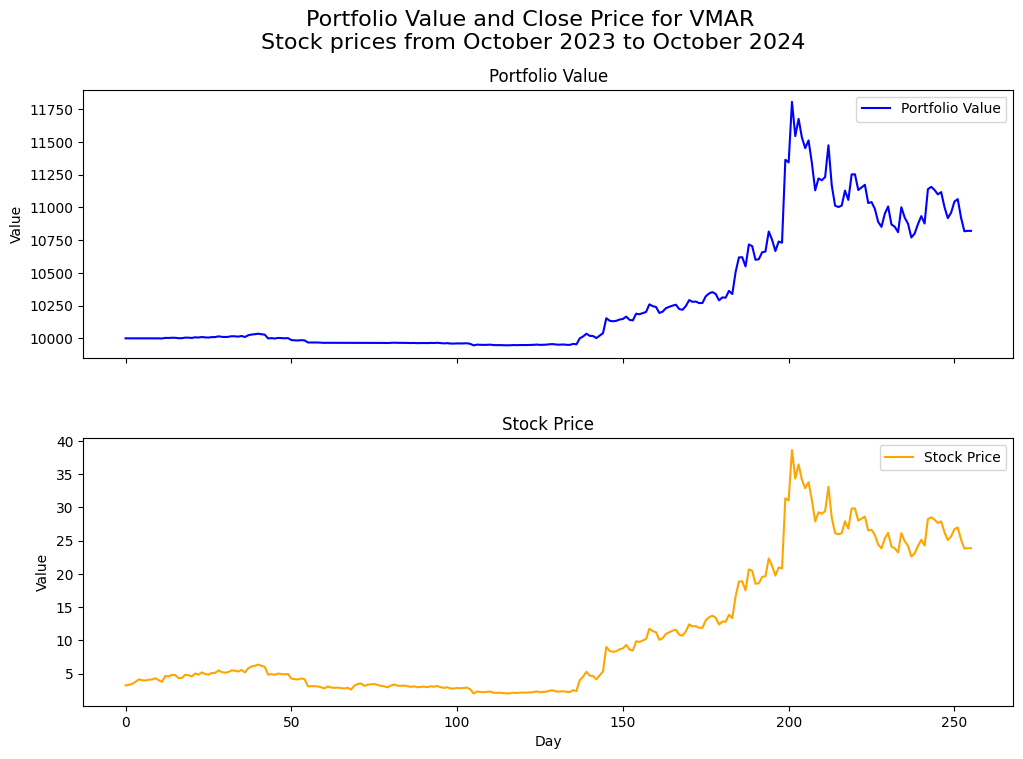

In [49]:
import matplotlib.pyplot as plt
results = VMAR[VMAR['Stock Name'] == 'ASTS']

# Set up a figure with two subplots, stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Portfolio Value on the first subplot
ax1.plot(results['Day'], results['Portfolio Value'], label='Portfolio Value', color='blue')
ax1.set_title('Portfolio Value')
ax1.set_ylabel('Value')
ax1.legend()

# Plot Stock Price on the second subplot
ax2.plot(results['Day'], results['Stock Price'], label='Stock Price', color='orange')
ax2.set_title('Stock Price')
ax2.set_xlabel('Day')
ax2.set_ylabel('Value')
ax2.legend()

# Set the main title and layout adjustments
fig.suptitle(f'Portfolio Value and Close Price for VMAR \nStock prices from October 2023 to October 2024', fontsize=16)
plt.subplots_adjust(hspace=0.3)

# Display the figure
plt.show()


,Day,Stock Price,Cash,Shares Held,Portfolio Value
count,765.000000,765.000000,765.000000,765.000000,765.000000
mean,382.000000,19.817346,8261.870344,82.900654,9785.112631
std,220.980768,7.066272,662.927043,38.640145,460.219870
min,0.000000,9.590000,7502.569983,0.000000,8961.790009
25%,191.000000,14.320000,7721.019983,52.000000,9474.689994
50%,382.000000,18.160000,8059.169983,93.000000,9787.720022
75%,573.000000,24.600000,8700.739995,113.000000,9972.890024
max,764.000000,43.320000,10000.000000,138.000000,11407.000158


In [22]:
LGBM_model_decisions[(LGBM_model_decisions['Action'] == 'Buy')]

,Stock Name,Day,Action,Stock Price,Cash,Shares Held,Portfolio Value,Date
1,A,1,Buy,142.740005,9857.259995,1.0,10000.000000,2024-10-10
5,A,5,Buy,139.110001,9718.149994,2.0,9996.369995,2024-10-16
16,AAPL,5,Buy,231.779999,9768.220001,1.0,10000.000000,2024-10-16
20,AAPL,9,Buy,234.899994,9533.320007,2.0,10003.119995,2024-10-22
21,AAPL,10,Buy,230.759995,9302.560013,3.0,9994.839996,2024-10-23
...,...,...,...,...,...,...,...,...
5509,ZBRA,9,Buy,372.600006,5522.119995,12.0,9993.320068,2024-10-22
5515,ZTS,4,Buy,192.389999,9807.610001,1.0,10000.000000,2024-10-15
5517,ZTS,6,Buy,191.000000,9616.610001,2.0,9998.610001,2024-10-17
5519,ZTS,8,Buy,189.449997,9427.160004,3.0,9995.509995,2024-10-21


In [23]:
specific_model_decisions[specific_model_decisions['Action']  == 'Buy']

,Stock Name,Day,Action,Stock Price,Cash,Shares Held,Portfolio Value,Date
13,AAPL,0,Buy,229.539993,9770.460007,1.0,10000.000000,2024-10-09
14,AAPL,1,Buy,229.039993,9541.420013,2.0,9999.500000,2024-10-10
62,ACGL,1,Buy,113.900002,9886.099998,1.0,10000.000000,2024-10-10
74,ACN,0,Buy,365.079987,9634.920013,1.0,10000.000000,2024-10-09
76,ACN,1,Buy,370.630005,9264.290009,2.0,10005.550018,2024-10-23
...,...,...,...,...,...,...,...,...
6460,ZBH,5,Buy,105.209999,9894.790001,1.0,10000.000000,2024-10-16
6461,ZBH,6,Buy,105.029999,9894.970001,1.0,10000.000000,2024-10-17
6462,ZBH,7,Buy,106.535004,9893.464996,1.0,10000.000000,2024-10-18
6463,ZBH,8,Buy,105.239998,9894.760002,1.0,10000.000000,2024-10-21


In [24]:
specific_model_decisions[(specific_model_decisions['Portfolio Value'] > 10000) & (specific_model_decisions['Day'] == specific_model_decisions['Day'].max())].sort_values(by='Portfolio Value', ascending=False)

,Stock Name,Day,Action,Stock Price,Cash,Shares Held,Portfolio Value,Date
791,BKNG,9,Sell,4374.654785,10082.654785,0.0,10082.654785,2024-10-22
5347,SNA,9,Buy,323.440002,9389.109985,2.0,10035.989990,2024-10-22
385,AMP,9,Buy,518.960022,8987.799988,2.0,10025.720032,2024-10-22
3248,ISRG,9,Sell,515.729980,10025.349976,0.0,10025.349976,2024-10-22
3738,LULU,9,Hold,298.225006,9725.880005,1.0,10024.105011,2024-10-22
...,...,...,...,...,...,...,...,...
3426,KEY,9,Sell,17.120001,10000.250000,0.0,10000.250000,2024-10-22
2680,GLW,9,Sell,46.950001,10000.220001,0.0,10000.220001,2024-10-22
960,CAG,9,Buy,29.415001,9941.275000,2.0,10000.105001,2024-10-22
3001,HST,9,Buy,17.495001,9965.054998,2.0,10000.045000,2024-10-22


In [25]:
LGBM_model_decisions[(LGBM_model_decisions['Portfolio Value'] > 10000) & (LGBM_model_decisions['Day'] == LGBM_model_decisions['Day'].max())].sort_values(by='Portfolio Value', ascending=False)

,Stock Name,Day,Action,Stock Price,Cash,Shares Held,Portfolio Value,Date
4113,PKG,10,Hold,228.649994,7807.849991,10.0,10094.349930,2024-10-23
1176,COST,10,Hold,899.169983,4648.799988,6.0,10043.819885,2024-10-23
538,AZO,10,Hold,3196.550049,6844.909912,1.0,10041.459961,2024-10-23
1000,CHTR,10,Hold,332.220001,7379.595032,8.0,10037.355042,2024-10-23
780,BX,10,Buy,166.919998,8701.619980,8.0,10036.979965,2024-10-23
...,...,...,...,...,...,...,...,...
4366,RJF,10,Hold,137.360001,9587.995010,3.0,10000.075012,2024-10-23
3035,KVUE,10,Buy,22.760000,9954.555000,2.0,10000.075001,2024-10-23
1077,CMG,10,Buy,59.020000,9823.000000,3.0,10000.060001,2024-10-23
3453,MNST,10,Hold,53.560001,9839.375000,3.0,10000.055004,2024-10-23


In [10]:
specific_model_decisions.describe()

,Day,Stock Price,Cash,Shares Held,Portfolio Value
count,6491.000000,6491.000000,6491.000000,6491.000000,6491.000000
mean,3.716531,222.373009,9893.637858,0.470563,10000.275433
std,2.918577,522.150942,511.583244,0.770765,10.018726
min,0.000000,7.330000,0.000000,0.000000,9734.150391
25%,1.000000,69.570000,9925.526850,0.000000,10000.000000
50%,3.000000,125.885002,10000.000000,0.000000,10000.000000
75%,6.000000,233.209999,10000.000000,1.000000,10000.000000
max,9.000000,9916.605469,10089.529785,4.000000,10289.005859


In [11]:
LGBM_model_decisions.describe()

,Day,Stock Price,Cash,Shares Held,Portfolio Value
count,6526.000000,6526.000000,6526.000000,6526.000000,6526.000000
mean,4.394422,222.785771,9750.905347,1.116315,9998.714805
std,3.243260,520.731735,695.793447,1.762561,12.672521
min,0.000000,7.330000,0.000000,0.000000,9592.934986
25%,1.000000,69.774998,9785.070007,0.000000,9999.761251
50%,4.000000,126.702499,9998.969997,0.000000,10000.000000
75%,7.000000,233.629997,10000.000000,2.000000,10000.000000
max,10.000000,9924.400391,10041.990234,20.000000,10150.820312


In [46]:
sim_results = VMAR
final_portfolio_values = get_final_portfolio_values(sim_results)#.drop(simResults[simResults['Stock Name']=='NFLX'].index))
final_portfolio_values['Profit %'] = (final_portfolio_values['Portfolio Value'] - 10000) / 10000 * 100
alt.Chart(final_portfolio_values).mark_bar().encode(
    x='Stock Name',
    y='Profit %',
    color=alt.condition(
        alt.datum['Profit %'] > 0,
        alt.value('green'),
        alt.value('red')
    )
).properties(
    title='Final Portfolio Value by Stock',
    width=800,
    height=400
).configure_axis(
    labelAngle=45
).display()

alt.Chart(...)

In [31]:
final_portfolio_values.describe() 

,Portfolio Value,Shares Held,Profit %
count,31.000000,31.000000,31.000000
mean,12289.470824,61.679765,22.894708
std,8031.005971,70.020174,80.310060
min,3701.635415,0.000000,-62.983646
25%,8540.845827,23.500000,-14.591542
50%,10111.734299,40.852725,1.117343
75%,12139.716903,65.593212,21.397169
max,42848.200941,344.243741,328.482009


In [32]:
sim_results0 = sim_results[sim_results['Stock Name'] != 'NVDA']
sim_results0['Profit %'] = (sim_results0['Portfolio Value'] - 10000) / 10000 * 100
sim_results0.describe()

,Day,Stock Price,Cash,Shares Held,Portfolio Value,Profit %
count,30701.000000,30701.000000,30701.000000,30701.000000,30701.000000,30701.000000
mean,496.086447,155.302177,5496.837378,43.505825,10278.839346,2.788393
std,287.866081,133.608014,3982.196742,53.977918,2881.863014,28.818630
min,0.000000,6.380000,0.000000,0.000000,3576.336032,-64.236640
25%,247.000000,47.606667,914.150009,7.000000,9794.985273,-2.050147
50%,495.000000,125.133781,6281.309988,28.000000,10000.000000,0.000000
75%,744.000000,222.770004,9530.074272,57.203117,10521.430099,5.214301
max,999.000000,772.070007,14576.403278,345.371173,47785.187495,377.851875


In [26]:
sim_results

,Stock Name,Day,Action,Stock Price,Cash,Shares Held,Portfolio Value,Date,Actual Sell
0,AAPL,0,Buy,115.97000122070312,10000,0,10000.0,2020-11-10,NaN
1,AAPL,1,Hold,119.48999786376953,10000,0,10000.0,2020-11-11,NaN
2,AAPL,2,Buy,119.20999908447266,10000,0,10000.0,2020-11-12,NaN
3,AAPL,3,Buy,119.26000213623047,10000,0,10000.0,2020-11-13,NaN
4,AAPL,4,Buy,120.30000305175781,10000,0,10000.0,2020-11-16,NaN
...,...,...,...,...,...,...,...,...,...
62398,EL,995,Hold,87.25,0,42.47430120178244,3705.8827798555176,2024-10-25,True
62399,EL,996,Hold,88.72000122070312,0,42.47430120178244,3768.32005447065,2024-10-28,True
62400,EL,997,Hold,88.75,0,42.47430120178244,3769.5942316581913,2024-10-29,True
62401,EL,998,Hold,87.1500015258789,0,42.47430120178244,3701.63541454598,2024-10-30,True


In [14]:
final_portfolio_values.describe()

,Portfolio Value,Shares Held,Profit %
count,29.000000,29.000000,29.000000
mean,12225.936234,71.548662,22.259362
std,4449.450537,74.875781,44.494505
min,9431.860641,0.000000,-5.681394
25%,10000.000000,23.000000,0.000000
50%,10892.311155,45.000000,8.923112
75%,11337.444018,92.000000,13.374440
max,31527.478527,252.179486,215.274785


In [15]:
all_stock_movement = []
total_movement = 0
for stock in sim_results['Stock Name'].unique():
    all_stock_movement.append([stock, get_stock_movement(stock)])
    total_movement += get_stock_movement(stock)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [16]:
total_movement/len(sim_results['Stock Name'].unique())


43.770230581058335

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
3718,2024-10-11,A,143.820007,143.820007,145.059998,143.059998,143.059998,1427400.0
3719,2024-10-14,A,144.250000,144.250000,145.070007,142.820007,144.000000,1765200.0
3720,2024-10-15,A,144.580002,144.580002,146.660004,144.070007,144.350006,1251200.0
3721,2024-10-16,A,139.110001,139.110001,142.565002,138.440002,141.509995,1412079.0
3722,2024-10-17,A,137.419998,137.419998,142.529999,136.479996,141.809998,1592900.0
3723,2024-10-18,A,138.634995,138.634995,139.520004,137.237503,138.529999,821460.0
3724,2024-10-21,A,136.800003,136.800003,138.809998,136.270096,138.350006,302912.0
3725,2024-10-22,A,133.570007,133.570007,134.750000,131.979996,134.690002,709278.0
3726,2024-10-23,A,133.029999,133.029999,134.300003,131.369995,133.270004,1652158.0
1874912,2024-10-24,A,131.781097,131.781097,133.309998,131.509995,133.139999,432792.0
